<a href="https://colab.research.google.com/github/mequanent/Music-Recommendation-Exercises/blob/main/MovieLens_NCF_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MovieLens Neural Collaborative Filtering (NCF) Model
This notebook creates and evaluates a neural network based recommendation model, based on NCF (Neural Collaborative Filtering).

We follow these steps:  
1. Data preparation - download the raw dataset, and prepare it for training and evaluation.
1. Model authoring - build the NCF neural network
1. Model training and evaluation - train our new model and benchmark it

Let's get to it!

## Step 1: Data preparation
We will start by loading the dataset

In [ ]:
from pathlib import Path
import shutil
import tempfile
import urllib.request
from urllib.request import urlopen
import zipfile
import pandas as pd

def load_movielens_dataset(dataset_name : str = 'ml-latest', workspace_path : str = Path.home() / 'data//movielens'):
  """
  Downloads, extracts, and loads MovieLens dataset 

  Args:
  dataset_name (string): dataset name to load, defaults to 'ml_latest'. Options listed here: https://grouplens.org/datasets/movielens/
  workspace_path (string): workspace path to use for downloading and extracting the archive, defaults to ~/data/movielens
  """
    
  archive_url = f'http://files.grouplens.org/datasets/movielens/{dataset_name}.zip'

  print(f'Downloading archive from: {archive_url}, this may take a few minutes...')
  
  with urllib.request.urlopen(archive_url) as response:
    with tempfile.NamedTemporaryFile(delete=True) as tmp_file:
      shutil.copyfileobj(response, tmp_file)
      with zipfile.ZipFile(tmp_file) as archive:
        archive.extractall(workspace_path)

  print(f'Archive files available at workspace: {workspace_path}')

  ratings = pd.read_csv(f'{workspace_path}/{dataset_name}/ratings.csv')
  movies = pd.read_csv(f'{workspace_path}/{dataset_name}/movies.csv')

  print(f'Loaded {ratings.shape[0]:,} ratings and {movies.shape[0]:,} movies.')

  return ratings, movies

# Let's load some movie ratings!
ratings, movies = load_movielens_dataset(dataset_name='ml-latest')
user_count = ratings["userId"].nunique()
movie_count = movies["movieId"].nunique()

Archive files available at workspace: /root/data/movielens
Loaded 27,753,444 ratings and 58,098 movies.


In [ ]:
# Let's peek into the loaded DataFrames
print('Sneak peek into the ratings DataFrame:\n\n', ratings.head(), '\n')
print(f'Number of users: {user_count:,}')
print(f'Number of ratings: {ratings.shape[0]:,}')
print(f'Number of rated movies: {ratings["movieId"].nunique():,}\n')
print(f'Sneak peek into the movies DataFrame:\n\n', movies.head(), '\n')
print(f'Number of movies: {movie_count:,} - notice this is higher than the number of rated movies!')


Sneak peek into the ratings DataFrame:

    userId  movieId  rating   timestamp
0       1      307     3.5  1256677221
1       1      481     3.5  1256677456
2       1     1091     1.5  1256677471
3       1     1257     4.5  1256677460
4       1     1449     4.5  1256677264 

Number of users: 283,228
Number of ratings: 27,753,444
Number of rated movies: 53,889

Sneak peek into the movies DataFrame:

    movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns] 

Number of movies: 58,098 - notice this is higher than the number of rated movies!


Next we divide our dataset into train and test, so we can later train and valuate the model.

In [ ]:
import numpy as np

# Define our input and labels data X,Y
X = ratings[['userId','movieId']]
Y = ratings['rating'].astype(np.float32)

# Let's set the split ratio and run the split
from sklearn.model_selection import train_test_split
random_state = 7
test_size = 0.2

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = random_state)
datasets = {'train': (X_train, Y_train), 'test': (X_test, Y_test)}

print(f'Training dataset sample size: {len(X_train):,} positive samples ({len(X_train)/len(X)*100:.0f}%)')
print(f'Test dataset sample size: {len(X_test):,} positive samples ({len(X_test)/len(X)*100:.0f}%)')
print(f'Total dataset sample size: {len(X):,} positive samples (100%)')

Training dataset sample size: 22,202,755 positive samples (80%)
Test dataset sample size: 5,550,689 positive samples (20%)
Total dataset sample size: 27,753,444 positive samples (100%)


## Step 2: Model authoring

We will move ahead to build the NCF neural network.  

Our model will learn to predict a user's rating for a given movie by learning  user and movie representations via dense embeddings, as well as user-item interactions via MLP (Multi Layer Perceptron).

Details of the architecture are in the [2017 paper by He et al.](https://dl.acm.org/doi/pdf/10.1145/3038912.3052569)

In [ ]:
import torch
from torch import nn

class NeuralColabFilteringNet(nn.Module):
    """
    Creates an NCF (Neural Collaborative Filtering) network, with configurable model architecture
    
    Args:
    user_count(int): Number of unique users in the dataset
    movie_count(int): Number of unique movies in the dataset
    embedding_size(int)[Optional]: Size of the user and movie embedding, defaults to 32
    hidden_layers(tuple)[Optional]: Tuple of integers defining the number of hidden MLP layers and the number of units in each layer, defaults to (64,32,16,8)
    dropout_rate(float)[Optional]: Dropout rate to apply after each layer in the range of [0 1], defaults to None
    output_range(tuple)[Optional]: Represents the output range, defaults to (1 5) per the star ratings
    """
    def __init__(self, 
                 user_count,
                 movie_count,
                 embedding_size=32,
                 hidden_layers=(64, 32, 16, 8),
                 dropout_rate=None,
                 output_range=(1, 5)):
      super().__init__()
      
      # Initialize embedding hash sizes
      self.user_hash_size = user_count
      self.movie_hash_size = movie_count

      # Initialize the model architecture components
      self.user_embedding = nn.Embedding(user_count, embedding_size)
      self.movie_embedding = nn.Embedding(movie_count, embedding_size)
      self.MLP = self._gen_MLP(embedding_size, hidden_layers, dropout_rate)
      if (dropout_rate):
        self.dropout = nn.Dropout(dropout_rate)
      
      # Initialize output normalization parameters 
      assert output_range and len(output_range) == 2, "output_range has to be a tuple with two integers"
      self.norm_min = min(output_range)
      self.norm_range = abs(output_range[0] - output_range[1]) + 1

      self._init_params()
    
    def _gen_MLP(self, embedding_size, hidden_layers_units, dropout_rate):
      "Generates the MLP portion of the model architecture"

      assert (embedding_size * 2) == hidden_layers_units[0], "First input layer number of units has to be equal to twice the embedding size!"
      
      hidden_layers = []
      input_units = hidden_layers_units[0]

      for num_units in hidden_layers_units[1:]:
        hidden_layers.append(nn.Linear(input_units, num_units))
        hidden_layers.append(nn.ReLU())
        if (dropout_rate):
          hidden_layers.append(nn.Dropout(dropout_rate))
        input_units = num_units
      
      hidden_layers.append(nn.Linear(hidden_layers_units[-1], 1))
      hidden_layers.append(nn.Sigmoid())
      return nn.Sequential(*hidden_layers)
    
    def _init_params(self):
      "Initializes model parameters"
      def weights_init(m):
          if type(m) == nn.Linear:
              torch.nn.init.xavier_uniform_(m.weight)
              m.bias.data.fill_(0.01)
              
      self.user_embedding.weight.data.uniform_(-0.05, 0.05)
      self.movie_embedding.weight.data.uniform_(-0.05, 0.05)
      self.MLP.apply(weights_init)

    def forward(self, user_id, movie_id):
      "Computes forward pass"
      user_features = self.user_embedding(user_id % self.user_hash_size)
      movie_features = self.movie_embedding(movie_id % self.movie_hash_size)
      x = torch.cat([user_features, movie_features], dim=1)
      if hasattr(self, 'dropout'):
        x = self.dropout(x)
      x = self.MLP(x)
      normalized_output = x * self.norm_range + self.norm_min
      return normalized_output

In [ ]:
# Now let's instantiate an NCF model and try a prediction with uninitialized weights
ncf = NeuralColabFilteringNet(user_count, movie_count)
print(f"Our model architecture:\n\n{ncf}\n")

# Let's look at the model size
num_params = sum(p.numel() for p in ncf.parameters())
print(f'Number of model parameters: {num_params:,}, model training size: {num_params*4/(1024**2):.2f} MB')

Our model architecture:

NeuralColabFilteringNet(
  (user_embedding): Embedding(283228, 32)
  (movie_embedding): Embedding(58098, 32)
  (MLP): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

Number of model parameters: 10,925,185, model training size: 41.68 MB


In [ ]:
from random import randrange
ncf.eval()

# Let's try a random prediction
ratings_row = randrange(0, ratings.shape[0] - 1)
test_user = int(ratings.iloc[ratings_row].userId)
test_movie = int(ratings.iloc[ratings_row].movieId)
actual_rating = ratings.iloc[ratings_row].rating

ncf.to('cpu')
predicted_rating = ncf(torch.tensor([test_user]), torch.tensor([test_movie]))
print(f"Dry run prediction for user-id:{test_user} and movie-id:{test_movie} is: {predicted_rating[0][0]}, actual rating is: {actual_rating}")

Dry run prediction for user-id:47642 and movie-id:648 is: 3.409848213195801, actual rating is: 3.0


## Step 3: Model training and evaluation
Finally, we will train and evaluate the NCF model we created.

In [ ]:
# We define an iterator to go over the dataset in batches
import numpy as np
import math

class DatasetBatchIterator:
  "Iterates over labaled dataset in batches"
  def __init__(self, X, Y, batch_size, shuffle=True):
    self.X = np.asarray(X)
    self.Y = np.asarray(Y)
    
    if shuffle:
      index = np.random.permutation(X.shape[0])
      X = self.X[index]
      Y = self.Y[index]

    self.batch_size = batch_size
    self.n_batches = int(math.ceil(X.shape[0] / batch_size))
    self._current = 0 
        
  def __iter__(self):
    return self
    
  def __next__(self):
    return self.next()
    
  def next(self):
    if self._current >= self.n_batches:
      raise StopIteration()
    k = self._current
    self._current += 1
    bs = self.batch_size
    X_batch = torch.LongTensor(self.X[k*bs:(k + 1)*bs])
    Y_batch = torch.FloatTensor(self.Y[k*bs:(k + 1)*bs])

    return X_batch, Y_batch.view(-1, 1)

In [ ]:
# Reset model's parameters, in case the cell is re-run
ncf._init_params()
ncf.train()

import time
from torch import optim
import copy

# Hyper parameters
lr = 1e-3
wd = 1e-4
batch_size = 2046
max_epochs = 50
early_stop_epoch_threshold = 3

# Training loop control parameters
no_loss_reduction_epoch_counter = 0
min_loss = np.inf
min_loss_model_weights = None
history = []
iterations_per_epoch = int(math.ceil(len(datasets['train']) // batch_size))
min_epoch_number = 1
epoch_start_time = 0

# Setup GPU, if available, else default to CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ncf.to(device)
print(f'Device configured: {device}')

# Configure loss and optimizer
loss_criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(ncf.parameters(), lr=lr, weight_decay=wd)

# Training loop - iterate over epochs, with early stopping
print(f'Starting training loop...')
training_start_time = time.perf_counter()
for epoch in range(max_epochs):
  stats = {'epoch': epoch + 1, 'total': max_epochs}
  epoch_start_time = time.perf_counter()

  # Every epoch runs training on train set, followed by eval on test set
  for phase in ('train', 'test'):
    is_training = phase == 'train'
    ncf.train(is_training)
    running_loss = 0.0
    n_batches = 0
      
    # Iterate on train/test datasets in batches
    for x_batch, y_batch in DatasetBatchIterator(datasets[phase][0], datasets[phase][1], batch_size=batch_size, shuffle=is_training):
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
          
      # We zero out the loss gradient, since PyTorch by default accumulates gradients  
      optimizer.zero_grad()

      # We need to compute gradients only during training
      with torch.set_grad_enabled(is_training):
        outputs = ncf(x_batch[:, 0], x_batch[:, 1])
        loss = loss_criterion(outputs, y_batch)

        if is_training:
          loss.backward()
          optimizer.step()
          
      running_loss += loss.item()
        
    # Compute overall epoch loss and update history tracker
    epoch_loss = running_loss / len(datasets[phase][0])
    stats[phase] = epoch_loss
    history.append(stats)
    
    # Handle early stopping
    if phase == 'test':
      stats['time'] = time.perf_counter() - epoch_start_time
      print('Epoch [{epoch:03d}/{total:03d}][Time:{time:.2f} sec] Train Loss: {train:.4f} / Validation Loss: {test:.4f}'.format(**stats))
      if epoch_loss < min_loss:
        min_loss = epoch_loss
        min_loss_model_weights = copy.deepcopy(ncf.state_dict())
        no_loss_reduction_epoch_counter = 0
        min_epoch_number = epoch + 1
      else:
        no_loss_reduction_epoch_counter += 1
  if no_loss_reduction_epoch_counter >= early_stop_epoch_threshold:
    print(f'Early stopping applied. Minimal epoch: {min_epoch_number}')
    break

print(f'Training completion duration: {(time.perf_counter() - training_start_time):.2f} sec. Validation Loss: {min_loss}')

Device configured: cuda:0
Starting training loop...
Epoch [001/050][Time:77.25 sec] Train Loss: 0.7508 / Validation Loss: 0.7078
Epoch [002/050][Time:77.05 sec] Train Loss: 0.6740 / Validation Loss: 0.6806
Epoch [003/050][Time:77.04 sec] Train Loss: 0.6239 / Validation Loss: 0.6772
Epoch [004/050][Time:77.01 sec] Train Loss: 0.5847 / Validation Loss: 0.6842
Epoch [005/050][Time:76.33 sec] Train Loss: 0.5578 / Validation Loss: 0.6933
Epoch [006/050][Time:76.29 sec] Train Loss: 0.5388 / Validation Loss: 0.7037
Early stopping applied. Minimal epoch: 3
Training completion duration: 460.98 sec. Validation Loss: 0.6772053082155587


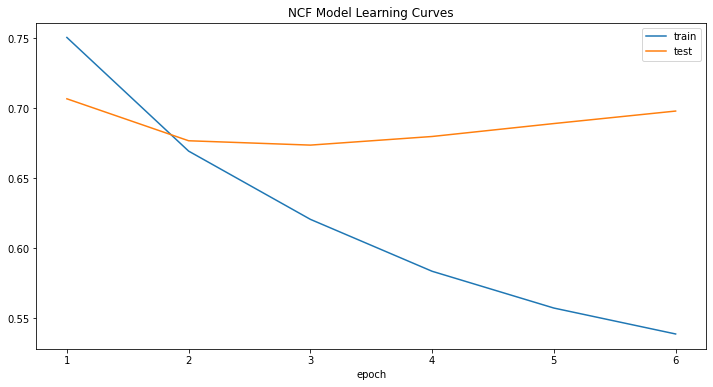

In [ ]:
# Now let's check out the learning curves
pd.DataFrame(history).drop(columns=['total','time']).plot(x='epoch', figsize=(12,6), title="NCF Model Learning Curves")

In [ ]:
# Let's go ahead and compute the model accuracy metric, we'll go with RMSE

ncf.load_state_dict(min_loss_model_weights)
ncf.eval()
groud_truth, predictions = [], []

with torch.no_grad():
    for x_batch, y_batch in DatasetBatchIterator(datasets['test'][0], datasets['test'][1], batch_size=batch_size, shuffle=False):
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      outputs = ncf(x_batch[:, 0], x_batch[:, 1])
      groud_truth.extend(y_batch.tolist())
      predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

RMSE = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {RMSE:.4f}')

Final RMSE: 0.8208


In [ ]:
# Let's try a few random prediction on the test set, just for fun!

from random  import randrange

ratings_row = randrange(0, len(datasets['test'][0]) - 1)
test_user = int(datasets['test'][0].iloc[ratings_row].userId)
test_movie = int(datasets['test'][0].iloc[ratings_row].movieId)
actual_rating = datasets['test'][1].iloc[ratings_row]

ncf.to('cpu')
ncf.eval()
predicted_rating = ncf(torch.tensor([test_user]), torch.tensor([test_movie]))
print(f"Dry run prediction for user-id:{test_user} and movie-id:{test_movie} is: {predicted_rating[0][0]}, actual rating is: {actual_rating}")

Dry run prediction for user-id:239670 and movie-id:1042 is: 3.0937116146087646, actual rating is: 3.0
